# Parametric Extended Kalman Filter(EKF) for GPS triangulation

This is a simple implementation of an Extended Kalman Filter for GPS triangulation. The filter is implemented in Python and tested with simulated data. The filter is able to estimate the position and velocity of a moving object given the GPS measurements with a certain accuracy.

## State Definition
The state of the system is defined as follows:
$$
\begin{align}
\mathbf{x} &= \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \\ z \\ \dot{z} \\ cdt \\ c\dot{dt}\end{bmatrix}
\end{align}
$$
where $x,y,z$ are the position of the object in the ECEF frame, $v_x,v_y,v_z$ are the velocity of the object in the ECEF frame, $cdt$ is the reciever clock bias and $c\dot{dt}$ is the reciever clock drift in units of meters.

## State transition function:
Assuming constant velocity model, the state transition function $F$ can be calculated by using the unit time step model:
$$
A = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}
$$
Now the state transition function can be calculated as:
$$
F = \begin{bmatrix} A & 0 & 0 & 0 \\ 0 & A & 0 & 0 \\ 0 & 0 & A & 0 \\ 0 & 0 & 0 & A \end{bmatrix}
$$
which is and 8x8 matrix which maps the state at time $t$ to the state at time $t+1$.

## Process noise
The continuous time process noise matrix $Q$ is defined as:
$$
Q = \int_{0}^{\Delta t} F(t)Q_cF^T(t) dt
$$
where $Q_c$ is the continuous process noise matrix. This is the projection of the continuous noise onto the discrete time model. Defining $Q_c$ as:
$$
Q_c = \begin{bmatrix} 0 & 0 \\ 0 & 1  \end{bmatrix} \cdot \Phi_{B}^2
$$
where $\Phi_{B}$ is the spectral density of the process noise.

Now we can project the continuous time process noise onto the discrete time model:
$$
Q_p = \int_{0}^{\Delta t} F(t)Q_cF^T(t) dt = \begin{bmatrix} \frac{1}{3}\Delta t^3 & \frac{1}{2}\Delta t^2 \\ \frac{1}{2}\Delta t^2 & \Delta t \end{bmatrix} \cdot \Phi_{B}^2
$$
The clock covariance can be modelled by a random walk process defined by $S_p$ the white noise spectral density leading to random walk velocity error, and $S_g$ the white noise spectral density leading to random walk clock drift error. The process noise matrix $Q_c$ is then defined as:
$$
Q_c = \begin{bmatrix} S_f \Delta t +\frac{S_g\Delta t^3}{3}, S_g\frac{\Delta t^2}{2} \\ S_g\frac{\Delta t^2}{2} , S_g \Delta t  \end{bmatrix}
$$

So the final process noise matrix $Q$ is defined as:
$$
Q = \begin{bmatrix} Q_p, 0, 0, 0 \\ 0, Q_p, 0, 0 \\ 0, 0, Q_p, 0 \\ 0, 0, 0, Q_c \end{bmatrix}
$$

## Measurement covariance
The measurement covariance matrix is defined to be a diagonal matrix with uncorrected standard deviation $\sigma_r$ of the measurements. The measurement covariance matrix is defined as:
$$
R = \begin{bmatrix} \sigma_r^2, 0, 0 , 0 \\ 0, \sigma_r^2, 0 , 0\\ 0, 0, \sigma_r^2 ,0 \\  0, 0, 0, \sigma_r^2 \end{bmatrix}
$$
where $\sigma_r$ is the standard deviation of the pseudorange measurements. 

# The Measurement function
The measurement function $h$ to convert the state to the measurement space. To convert the state vector to the measurement space, we need to calculate the distance between the reciever and the GPS satellites plus the reciever clock offset error. Hence, the measurement function $h$ is defined as:
$$
h(x_s , s_i) = \sqrt {(x_s - x_i)^2 + (y_s - y_i)^2 + (z_s - z_i)^2} + cdt
$$
This is a non-linear function and hence a non-linear filter is required to estimate the state of the system.

In [1]:
%load_ext autoreload
%autoreload 2
from navigator.epoch import Epoch, from_rinex_files, EpochCollection
from pathlib import Path


obsPath = Path("data/JPLM00USA_R_20223230000_01D_30S_MO.crx.gz")
navPath = Path("data/JPLM00USA_R_20223230000_01D_GN.rnx.gz")

epoches = list(from_rinex_files(
    observation_file=obsPath,
    navigation_file=navPath,
    profile=Epoch.DUAL
))

Processing 2022-11-19 23:59:30: 100%|██████████| 2880/2880 [00:05<00:00, 495.43it/s]


Since these are the collection of continouos epoches, we wrap the list of the Epoches into an epoches collection.

In [2]:
collection = EpochCollection(
    epochs=epoches,
)

Not to run the EKF, we need a continuoius visiblily of the tracked satellites. This continuous visiblity allows us to run the extended kalman filter to filter the states.

In [3]:
ctg0 = collection.track(mode=EpochCollection.VISIBILITY)[0]

Let's set up the WLS, PEKF and EKF traingulation algorathim for testing

In [4]:
from navigator.core import IterativeTriangulationInterface
import torch
CODE_ONLY = False
z, sv_pos = IterativeTriangulationInterface.epoches_to_timeseries(
    epoches=ctg0,
    sv_filter=ctg0[0].common_sv,
    code_only=CODE_ONLY
)

# Convert to torch tensor
z = torch.tensor(z, dtype=torch.float64)
sv_pos = torch.tensor(sv_pos, dtype=torch.float64)

In [5]:
from navigator.core import  ExtendedKalmanInterface, Triangulate, IterativeTriangulationInterface

# Define the Iterative Triangulation Interface to compare with the EKF
tri_wls = Triangulate(
    interface=IterativeTriangulationInterface(
        code_only=CODE_ONLY

    )
)

df_wls = tri_wls.triangulate_time_series(epoches=ctg0)

Triangulating: 100%|██████████| 171/171 [00:20<00:00,  8.29it/s]


Let's define the state and measurement dimensions and necessary variables.

In [14]:
from navigator.neural import (
    ParametricExtendedInterface,
    SymmetricPositiveDefiniteMatrix,
    DiagonalSymmetricPositiveDefiniteMatrix,
    TransitionModel,
    ObservationModel,
    discretized_process_noise_matrix,
    BiasedObservationModel)
from navigator.core import  ExtendedKalmanInterface, Triangulate, IterativeTriangulationInterface
import numpy as np


# Define the state dimension and measurement dimension
DIM_STATE = 8
DIM_MEASUREMENT = len(ctg0[0]) if CODE_ONLY else 2 * len(ctg0[0])   # Length of the satellites in first epoch
DT = 30.0
# Define the initial state
x0 = torch.zeros(DIM_STATE)
P0 = torch.eye(DIM_STATE) * 1e5

# Define the process noise
Q_AUT = torch.eye(DIM_STATE) * 1e-6
Q = discretized_process_noise_matrix(dt=DT, Q_0=Q_AUT)
R = torch.eye(DIM_MEASUREMENT) * 64



Lets set up the classical EKF first and get the estimation. 

In [15]:
# Define the Extend Kalman Interface
eki = ExtendedKalmanInterface(
    dt=30.0, # This data is in 30s interval
    num_sv=DIM_MEASUREMENT, # Number of satellites
    x0=x0.numpy(), # Prior state
    P0=P0.numpy(), # Prior covariance
    R=R.numpy(), # Measurement noise
    Q_0=Q_AUT.numpy(), # Process noise
    log_innovation=True, # Log the innovation
    code_only=True,  # Genrally num_sv and dim measuremnt is different if using phase measurements, but we already adjusted that in dim_measurements

)

ekf_state, ekf_resudials = eki.fixed_interval_smoothing(
    x0=x0.numpy(),
    P0=P0.numpy(),
    z=z.numpy(),
    sv_pos=sv_pos.numpy()
)

Let's set up the PEKF for training and hyperparameter estimation

In [16]:

# Define the noise models
q_module = SymmetricPositiveDefiniteMatrix(M=Q, trainable=True)
r_module = DiagonalSymmetricPositiveDefiniteMatrix(M=R, trainable=True)

# Define the transition model
transistion_model = TransitionModel(
    dt=DT,
    learnable=False,
)
observation_model = ObservationModel(
    trainable=False,
    dim_measurement=DIM_MEASUREMENT,
)

pekf = ParametricExtendedInterface(
    dt=DT,
    dim_z=DIM_MEASUREMENT,
    f=transistion_model,
    h=observation_model,
    Q=q_module,
    R=r_module,
    objective=ParametricExtendedInterface.NEGATIVE_LOG_LIKELIHOOD,
).to(torch.float64)


Now let's preprocess the tensors to computational format i.e range_measurements, satellite positions which will apply all the preprocessing given in epoch profile

In [17]:
import torch.optim as optim

TUNING_LENGTH = 50
MAX_EPOCHES = 100

z_tune = z[:TUNING_LENGTH]
sv_pos_tune = sv_pos[:TUNING_LENGTH]


# Set the learning rate for the optimizer
LR_Q = 1e-3
LR_R = 1e-3
LR_H = 1e-5
LR_F = 1e-5

GAMMA = (1/100) ** (1/MAX_EPOCHES)

params = [
    {'params': q_module.parameters(), 'lr': LR_Q }, # L2 Regularization
    {'params': r_module.parameters(), 'lr': LR_R,}, # L2 Regularization
    {'params': transistion_model.parameters(), 'lr': LR_F},
    {'params': observation_model.parameters(), 'lr': LR_H},
]

optimizer = optim.Adam(params, lr=1e-3)

explrs = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

Let's tune the PEKF on the tuning dataset

In [18]:
output = pekf.tune(
    z=z_tune,
    x0=x0,
    P0=P0,
    sv_pos=sv_pos_tune,
    lr_scheduler=None,
    max_epochs=MAX_EPOCHES,
    clip_grad_norm=1000,
)

Epoch 0: Loss = 27038360064.2245, Q_grad_norm = 3968671806.196714, R_grad_norm = 73814684.66811484, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 1: Loss = 14107759806.863756, Q_grad_norm = 5427325854.641763, R_grad_norm = 57393183.098413624, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 2: Loss = 11258521373.270433, Q_grad_norm = 1142424715.2717113, R_grad_norm = 52620834.22234754, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 3: Loss = 9990074199.231567, Q_grad_norm = 741224403.505499, R_grad_norm = 45512246.20947275, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 4: Loss = 9379591952.420927, Q_grad_norm = 109591670.42726618, R_grad_norm = 44240649.808141544, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 5: Loss = 9188403904.928392, Q_grad_norm = 34569096.39256566, R_grad_norm = 43809336.85934101, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 6: Loss = 9055900159.286354, Q_grad_norm = 19697835.02483456, R_grad_norm = 43200877.29420602, f_grad_norm = 0.0, h_grad_norm = 0.0
Epoch 7: Loss = 8919655606.221

Let's plot the log likelihood of the data

Text(0.5, 1.0, 'Loss vs Epoch')

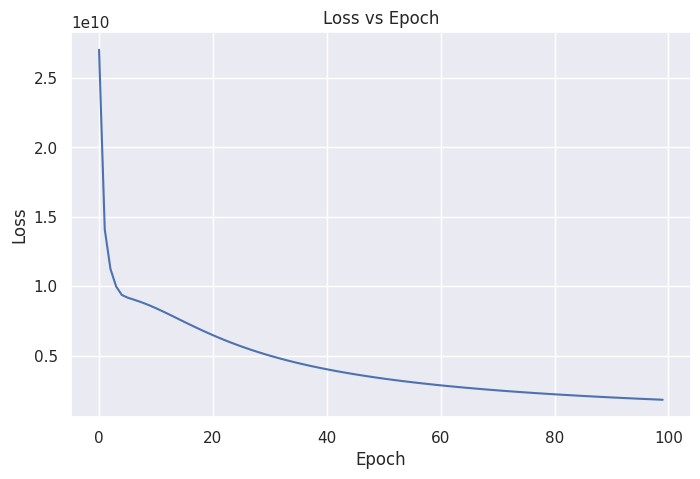

In [19]:
# Plot the loss
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="darkgrid"
)
loss_plt , ax = plt.subplots(
    figsize=(8, 5)
)

# Plot the loss
ax.plot(output['losses'])

# Set the labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# Set the title
ax.set_title("Loss vs Epoch")

Let's predict using PEKF

In [21]:
with torch.no_grad():
    outs = pekf.batch_smoothing(
        z=z,
        x0=x0,
        P0=P0,
        sv_pos=sv_pos,
    )

This shows the autocorreleation function of the residuals

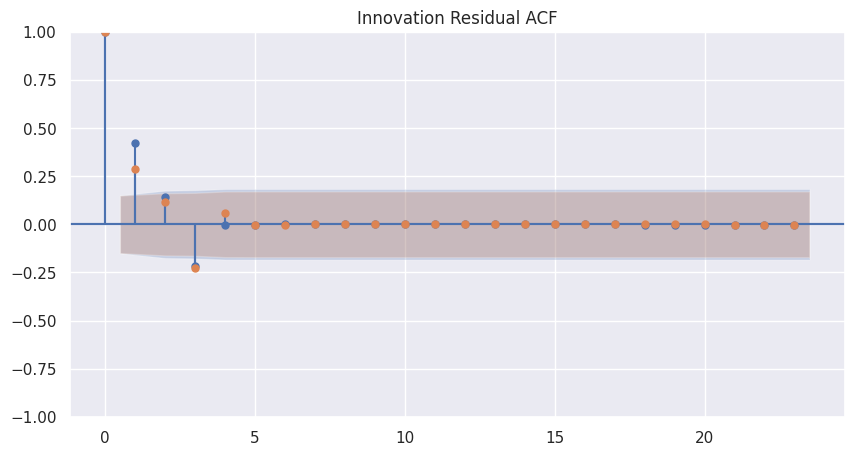

In [22]:
# Import plot afc function
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

afc_plot , ax = plt.subplots(1, 1, figsize=(10, 5))

plot_acf(
    x=outs["innovation_residual"][:, 0], ax=ax
);
plot_acf(
    x=ekf_resudials["innovation_residual"][:, 0], ax=ax,
);

ax.set_title("Innovation Residual ACF");

Let's see the error plots

In [29]:
import pandas as pd
pekf_states = pd.DataFrame(outs["x_smoothed"], columns=ParametricExtendedInterface.STATE_NAMES)
ekf_states = pd.DataFrame(ekf_state, columns=ParametricExtendedInterface.STATE_NAMES)
wls_states = pd.DataFrame(df_wls, columns=ParametricExtendedInterface.STATE_NAMES)

We know the real coordinates since this is the IGS station.

In [24]:
realCoords = pd.DataFrame(
    data=Epoch.IGS_NETWORK.get_xyz(station="JPLM00USA").reshape(1,-1).repeat(len(ctg0), axis=0),
    columns=["x", "y", "z"]
)

Let's calcualte the ENU error from this triangulation.

In [25]:
from navigator.core import  Triangulate


enuError_PEKF = Triangulate.enu_error(
    predicted=pekf_states,
    actual=realCoords
)
enuError_EKF = Triangulate.enu_error(
    predicted=ekf_states,
    actual=realCoords
)

enuError_WLS = Triangulate.enu_error(
    predicted=wls_states,
    actual=realCoords
)


The boxen plot of the ENU error by model is shown below:

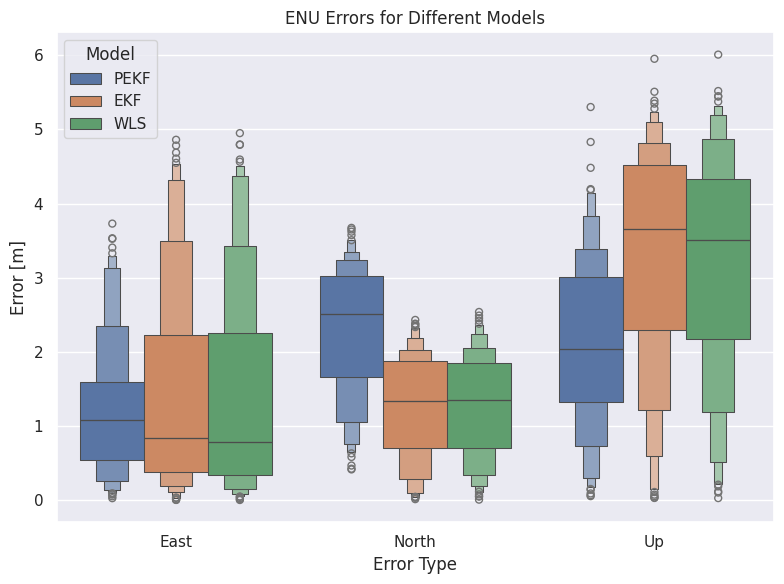

In [26]:
fig = Triangulate.enu_boxen_plot(
    error_dict={
        "PEKF": enuError_PEKF[20:],
        "EKF": enuError_EKF[20:],
        "WLS": enuError_WLS[20:]
    }
);

Let's calculate the total error associated with the model

In [27]:
totalError = pd.DataFrame(
{
    "PEKF": enuError_PEKF.apply(np.linalg.norm, axis=1),
    "EKF": enuError_EKF.apply(np.linalg.norm, axis=1),
    "WLS": enuError_WLS.apply(np.linalg.norm, axis=1)
}
)

Let's plot the total error distribution.

<Axes: >

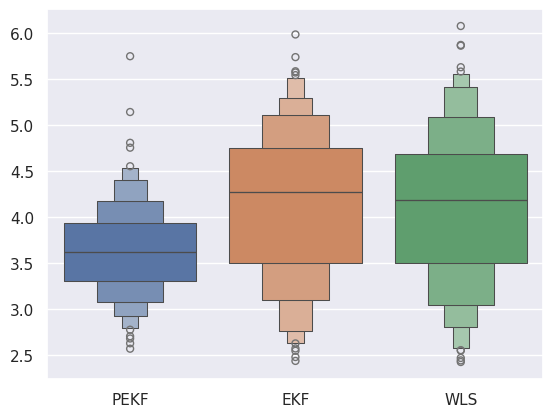

In [30]:
# Plot the total error
sns.boxenplot(data=totalError[30:])